In [1]:
import sys, os, random, glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import pearsonr
from scipy.special import erf

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# torch
sys.path.append("../")
import torch
from src.models.anomrecon_module import AnomReconModule
from src.data.anomrecon_datamodule import AnomReconDataModule

from omegaconf import OmegaConf

# Models Trained on ERA5

In [2]:
%%capture

PROJECT_ROOT = '..'#'/home/acamilletti/anom_recon/seasonal'
path         = PROJECT_ROOT + '/logs/t2m_NDJFM_ERA5/multiruns/nolkb_multiseed/'
ckpt         = glob.glob(f'{path}/?/checkpoints/epoch_???.ckpt')
n_models     = len(ckpt)
#ckpt         = ['epoch_159', 'epoch_139', 'epoch_126', 'epoch_120']

model = []
for i in range(0,n_models):
    os.environ['PROJECT_ROOT'] = PROJECT_ROOT
    config             = OmegaConf.load('%s/%s/.hydra/config.yaml' % (path, i))
    indexes_paths      = config['data']['indexes_paths']
    anomalies_path     = config['data']['anomalies_path']
    land_sea_mask_path = config['data']['land_sea_mask_path']
    orography_path     = config['data']['orography_path']
    lookback_paths     = config['data']['lookback_paths']
    lookback           = config['data']['lookback']
    lookforward        = config['data']['lookforward']
    leadtime           = config['data']['leadtime']
    num_indexes        = config['data']['num_indexes']
    num_pca            = config['data']['num_pca']
    months             = config['data']['months']
    train_last_date    = config['data']['train_last_date']
    batch_size         = config['data']['batch_size']
    num_workers        = config['data']['num_workers']
    seed               = config['seed']

    datamodule = AnomReconDataModule(
        indexes_paths=indexes_paths,
        anomalies_path=anomalies_path,
        land_sea_mask_path=land_sea_mask_path,
        orography_path=orography_path,
        lookback_paths=lookback_paths,
        lookback=lookback,
        lookforward=lookforward,
        leadtime=leadtime,
        months=months,
        num_indexes=num_indexes,
        num_pca=num_pca,
        train_last_date=train_last_date,
        )
    datamodule.setup(stage='test')
    
    model.append(
        AnomReconModule.load_from_checkpoint(
            ckpt[i]
            ).to('cpu')
        )
    
    model[i].eval()

In [3]:
idxs = xr.open_dataarray(indexes_paths[0]).sel(mode=slice(1,num_indexes[0]))
anom = xr.open_dataarray(anomalies_path)

In [4]:
# set day = 1 for every date
times = pd.to_datetime(
        pd.DataFrame(
            data={'years': idxs.time.dt.year.data, 'months': idxs.time.dt.month.data, 'days': 1},
            dtype=int
            ),
        ).values
idxs['time'] = times
anom['time'] = times

In [5]:
#anom = anom.rename({'latitude': 'lat', 'longitude': 'lon'})

In [6]:
def get_models_inputs(start_year):
    concat_dset = torch.utils.data.ConcatDataset((datamodule.data_val, datamodule.data_test))
    years  = [concat_dset[i][0][0] for i in range(len(concat_dset))]
    months = [concat_dset[i][0][1] for i in range(len(concat_dset))]
    #days   = [pd.Period('%d-%d' % (z[0] + start_year, z[1])).days_in_month for z in zip(years, months)]
    days   = 1
    static_data = concat_dset[0][0][3]

    times = pd.to_datetime(
        pd.DataFrame(
            data={'years': np.array(years) + start_year, 'months': months, 'days': days},
            dtype=int
            ),
        ).values

    return years, months, times, static_data

def get_model_out(model, years, months, times, indexes, static_data):
    
    outputs = []
    for i in range(len(years)):
        time = times[i]
        index = torch.tensor(
            indexes.sel(time=time).data,
            dtype=torch.float32
            )
        
        x = years[i], months[i], index, static_data, torch.tensor(0)
        x = [el.unsqueeze(0) for el in x]
        outputs.append(model(x).squeeze(0).detach())
    
    return outputs

def get_models_out(models, indexes, start_year=1940):
    model_out = xr.DataArray(
        dims=['time', 'lat', 'lon', 'number'],
        coords=dict(
            time=anom.time,
            lat=anom.lat,
            lon=anom.lon,
            number=np.arange(1,len(models)+1)
        )
    )
    
    years, months, times, static_data = get_models_inputs(start_year)

    for number in range(1, len(models)+1):
        model_out.loc[dict(time=times, number=number)] = get_model_out(models[number-1], years, months, times, indexes, static_data)
        
    return model_out.dropna(dim='time')

In [7]:
models_out = get_models_out(model, idxs)

# Compute Perturbed Models' Output
### (from perturbed indexes)

In [8]:
# compute mean absolute value of a normally distributed variable
def mean_absolute_value(mu, sigma):
    phi = .5 * (1 + erf(-mu / (2**.5 * sigma)))
    return sigma * (2/np.pi)**.5 * np.exp(-mu**2/ (2*sigma**2)) + mu * (1 - 2*phi)

def sigma_from_mu_and_mare(mu, mare, min=1e-3, max=10, eps=1e-5):
    if mare == 0:
        return 0
    for sigma in np.linspace(min, max, int(1e6)):
        if abs(mean_absolute_value(mu, sigma) - mare) <= eps:
            return sigma
    raise Exception('sigma not found in the range %.2e -- %.2e' % (min, max))

In [9]:
# generate N realization of gaussian perturbation
# such that the mean relative error and the 
# mean absolute relative error are given: 
# the first will fix the mean, the sencod the standard deviation
N         = int(25)                                                        # number of realizations
idx_mre   = 0                                                              # mean relative error
idx_mare  = .3                                                             # mean absolute relative error
pert_idxs = np.zeros((N, *idxs.shape))                                     # perturbed indexes

# compute the factor f for the perturbation:
# error = index * f
mu    = idx_mre
sigma = sigma_from_mu_and_mare(mu, idx_mare)
f     = np.random.normal(loc=mu, scale=sigma, size=(N, *idxs.shape))

# compute the perturbations
for i in range(N):
    pert_idxs[i] = idxs.data * (1 + f[i])


# transform to xarray for convenience
pert_idxs = xr.DataArray(
    data=pert_idxs,
    dims=['realization', 'mode', 'time'],
    coords=dict(
        time=idxs.time,
        mode=idxs.mode,
        realization=range(1, N+1)
    )
)

In [10]:
def get_perturbed_models_out(models, pert_idxs):    
    model_out = xr.DataArray(
        dims=['realization', 'time', 'lat', 'lon', 'number'],
        coords=dict(
            realization=pert_idxs.realization,
            time=pert_idxs.time,
            lat=anom.lat,
            lon=anom.lon,
            number=np.arange(1,len(models)+1)
        )
    )

    years, months, times, static_data = get_models_inputs(start_year=1940)


    for realization in pert_idxs.realization:
        rel_idxs = pert_idxs.sel(realization=realization)

        for number in range(1, len(models)+1):
            model_out.loc[dict(realization=realization, time=times, number=number)] = get_model_out(models[number-1], years, months, times, rel_idxs, static_data)
        
    return model_out.dropna(dim='time')

In [11]:
pert_models_out = get_perturbed_models_out(model, pert_idxs)

# Compute Random Models' output
### (from random indexes)

In [12]:
rand_idxs = xr.DataArray(
    data=np.random.normal(0, 1, size=(N, *idxs.shape)),
    dims=['realization', 'mode', 'time'],
    coords=dict(
        time=idxs.time,
        mode=idxs.mode,
        realization=range(1,N+1)
    )
)
rand_models_out = get_perturbed_models_out(model, rand_idxs)

# Compute Model's output using SEAS5 indexes

In [13]:
# read ERA5 temperature
era5 = xr.open_dataarray("../data/monthly_t2m_europe_19400101-20241231_regrid.nc")

# ERA5 climatology
clim_start = '1981-01-01'
clim_end   = '2010-12-31'
era5_clim = era5.sel(time=slice(clim_start, clim_end)).groupby('time.month').mean()
era5_anom = era5.groupby('time.month') - era5_clim

# read bias corected SEAS5
seas5_anom = xr.open_dataarray("../data/SEAS5_t2m_anom_europe_clim1981-2010_bias1993-2016_20170101-20250101.nc").transpose('time', 'forecastMonth', 'lat', 'lon', 'number').sel(time=slice(None, '2024'))

# read bias corrected SEAS5 indexes
seas5_idxs = xr.open_dataarray('../data/SEAS5_bias_corrected_monthly_z500_pc_noa_20170101-20241201.nc').sel(mode=slice(1, num_indexes[0]))
seas5_idxs = seas5_idxs[:, np.isin(seas5_idxs.time.dt.month, (11,12,1,2,3))]

In [14]:
models_seas5_index = xr.DataArray(
    dims=['time', 'lat', 'lon', 'forecastMonth', 'ensemble_member', 'number'],
    coords=dict(
        time=seas5_idxs.time,
        lat=anom.lat,
        lon=anom.lon,
        forecastMonth=seas5_idxs.forecastMonth,
        ensemble_member=seas5_idxs.number.data,
        number=range(1, n_models+1)
    )
)

for leadtime in seas5_idxs.forecastMonth.data:
    for ensemble_member in seas5_idxs.number.data:
        print(f"{leadtime}, {ensemble_member}    ", end='\r')
        models_seas5_index.loc[dict(forecastMonth=leadtime, ensemble_member=ensemble_member)] = get_models_out(model, seas5_idxs.sel(forecastMonth=leadtime, number=ensemble_member))

# Models trained on SEAS5 indexes

In [15]:
%%capture

seas5_models_out = []
for leadtime in range(1,5):
    path                = PROJECT_ROOT + f'/logs/t2m_NDJFM_SEAS5/multiruns/leadtime-{leadtime}/'
    ckpt                = glob.glob(f'{path}/?/checkpoints/epoch_???.ckpt')
    n_seas5_models      = len(ckpt)

    seas5_model = []
    for i in range(0,n_models):
        os.environ['PROJECT_ROOT'] = PROJECT_ROOT
        config             = OmegaConf.load('%s/%s/.hydra/config.yaml' % (path, i))
        indexes_paths      = config['data']['indexes_paths']
        anomalies_path     = config['data']['anomalies_path']
        land_sea_mask_path = config['data']['land_sea_mask_path']
        orography_path     = config['data']['orography_path']
        lookback_paths     = config['data']['lookback_paths']
        lookback           = config['data']['lookback']
        lookforward        = config['data']['lookforward']
        leadtime           = config['data']['leadtime']
        num_indexes        = config['data']['num_indexes']
        num_pca            = config['data']['num_pca']
        months             = config['data']['months']
        train_last_date    = config['data']['train_last_date']
        batch_size         = config['data']['batch_size']
        num_workers        = config['data']['num_workers']
        seed               = config['seed']

        datamodule = AnomReconDataModule(
            indexes_paths=indexes_paths,
            anomalies_path=anomalies_path,
            land_sea_mask_path=land_sea_mask_path,
            orography_path=orography_path,
            lookback_paths=lookback_paths,
            lookback=lookback,
            lookforward=lookforward,
            leadtime=leadtime,
            months=months,
            num_indexes=num_indexes,
            num_pca=num_pca,
            train_last_date=train_last_date,
            )
        datamodule.setup(stage='test')
        
        seas5_model.append(
            AnomReconModule.load_from_checkpoint(
                ckpt[i]
                ).to('cpu')
            )
        
        seas5_model[i].eval()


    seas5_models_out.append(get_models_out(seas5_model, xr.open_dataarray(indexes_paths[0]).sel(mode=slice(1,num_indexes[0])), start_year=1981).mean(dim='number'))

 ## Winter season

In [16]:
# reduce era5, model_out and seas5 to the same time range
start = pd.to_datetime(
    max(seas5_anom.time.min().data, models_out.time.min().data)
    )
end = pd.to_datetime(
    min(seas5_anom.time.max().data, models_out.time.max().data)
    )

anom               = anom.sel(time=slice(start, end))
idxs               = idxs.sel(time=slice(start, end))
era5_anom          = era5_anom.sel(time=slice(start, end))
seas5_anom         = seas5_anom.sel(time=slice(start, end))
pert_idxs          = pert_idxs.sel(time=slice(start, end))
models_out         = models_out.sel(time=slice(start, end))
pert_models_out    = pert_models_out.sel(time=slice(start, end))
models_seas5_index = models_seas5_index.sel(time=slice(start, end))
seas5_models_out   = [seas5_models_out[i].sel(time=slice(start, end)) for i in range(len(seas5_models_out))]

In [17]:
anom_DJF         = anom[np.isin(anom.time.dt.month, (12,1,2))]
models_DJF       = models_out[np.isin(models_out.time.dt.month, (12,1,2))]
pert_models_DJF  = pert_models_out.transpose('time', 'lat', 'lon', 'number', 'realization')[np.isin(pert_models_out.time.dt.month, (12,1,2))]
rand_models_DJF  = rand_models_out.transpose('time', 'lat', 'lon', 'number', 'realization')[np.isin(rand_models_out.time.dt.month, (12,1,2))]

In [18]:
seas5_decs =  seas5_anom[seas5_anom.time.dt.month == 11].sel(forecastMonth=2).drop_vars({'forecastMonth'})  # prediction of Dec from 1st of Nov
seas5_jans =  seas5_anom[seas5_anom.time.dt.month == 11].sel(forecastMonth=3).drop_vars({'forecastMonth'})  # prediction of Jan from 1st of Nov
seas5_febs =  seas5_anom[seas5_anom.time.dt.month == 11].sel(forecastMonth=4).drop_vars({'forecastMonth'})  # prediction of Feb from 1st of Nov

# shift the time to the predicted time
seas5_decs['time'] = pd.to_datetime(seas5_decs['time']) + pd.DateOffset(months=1)
seas5_jans['time'] = pd.to_datetime(seas5_jans['time']) + pd.DateOffset(months=2)
seas5_febs['time'] = pd.to_datetime(seas5_febs['time']) + pd.DateOffset(months=3)

seas5_DJF = xr.concat((seas5_decs, seas5_jans, seas5_febs), dim='time').sortby('time')

In [19]:
models_seas5_index_decs =  models_seas5_index[models_seas5_index.time.dt.month == 11].sel(forecastMonth=2).drop_vars({'forecastMonth'})  # prediction of Dec from 1st of Nov
models_seas5_index_jans =  models_seas5_index[models_seas5_index.time.dt.month == 11].sel(forecastMonth=3).drop_vars({'forecastMonth'})  # prediction of Jan from 1st of Nov
models_seas5_index_febs =  models_seas5_index[models_seas5_index.time.dt.month == 11].sel(forecastMonth=4).drop_vars({'forecastMonth'})  # prediction of Feb from 1st of Nov

# shift the time to the predicted time
models_seas5_index_decs['time'] = pd.to_datetime(models_seas5_index_decs['time']) + pd.DateOffset(months=1)
models_seas5_index_jans['time'] = pd.to_datetime(models_seas5_index_jans['time']) + pd.DateOffset(months=2)
models_seas5_index_febs['time'] = pd.to_datetime(models_seas5_index_febs['time']) + pd.DateOffset(months=3)

models_seas5_index_DJF = xr.concat((models_seas5_index_decs, models_seas5_index_jans, models_seas5_index_febs), dim='time').sortby('time')

In [20]:
seas5_models_DJF = xr.concat(
    (
        seas5_models_out[1][seas5_models_out[1].time.dt.month == 12],
        seas5_models_out[2][seas5_models_out[2].time.dt.month == 1],
        seas5_models_out[3][seas5_models_out[3].time.dt.month == 2],
    ),
    dim='time').sortby('time')

In [21]:
# reduce to common time
DJF_start = max(
    seas5_DJF.time.min(),
    models_DJF.time.min()
)
DJF_end   = min(
    seas5_DJF.time.max(),
    models_DJF.time.max()
)
anom_DJF               = anom_DJF.sel(time=slice(DJF_start, DJF_end))
models_DJF             = models_DJF.sel(time=slice(DJF_start, DJF_end))
seas5_DJF              = seas5_DJF.sel(time=slice(DJF_start, DJF_end))
pert_models_DJF        = pert_models_DJF.sel(time=slice(DJF_start, DJF_end))
rand_models_DJF        = rand_models_DJF.sel(time=slice(DJF_start, DJF_end))
models_seas5_index_DJF = models_seas5_index_DJF.sel(time=slice(DJF_start, DJF_end))
seas5_models_DJF       = seas5_models_DJF.sel(time=slice(DJF_start, DJF_end))

# Skill Assessment

In [22]:
# plotting functions
def boxplot(q, color, label):
    bplot = plt.boxplot(
        [q[0].data.flatten(),
        q[1].data.flatten(),
        q[2].data.flatten(),
        np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,np.nan ,
        q[3].data.flatten(),
        q[4].data.flatten()],
        tick_labels=['', '', '', '', '', '', '', '', '', '', '', ''],
        patch_artist=True,
        showmeans=True, boxprops={'color': color},
        medianprops={'linewidth': 0, 'color': color}, 
        meanprops={'marker': 's', 'markeredgecolor': color, 'markerfacecolor': color}, 
        showfliers=False,
        whiskerprops={'color': color}, capprops = {'color': color},
        label=label
    )
    [patch.set(facecolor=color, alpha=.2) for patch in bplot['boxes']]

def boxplot_NDJFM(q, color, label, pos):
    bplot = plt.boxplot(
        [q[-2].data.flatten(),
        q[-1].data.flatten(),
        q[0].data.flatten(),
        q[1].data.flatten(),
        q[2].data.flatten(),
        ],
        positions=pos,
        tick_labels=['', '', '', '', ''],
        patch_artist=True,
        showmeans=True, boxprops={'color': color},
        medianprops={'linewidth': 0, 'color': color}, 
        meanprops={'marker': 's', 'markeredgecolor': color, 'markerfacecolor': color}, 
        showfliers=False,
        whiskerprops={'color': color}, capprops = {'color': color},
        widths=.8,
        label=label
    )
    [patch.set(facecolor=color, alpha=.2, hatch='///') for patch in bplot['boxes']]

## Mean Absolute Error

In [23]:
# seas5 error (wrt era5 anomalies)
seas5_mae = xr.DataArray(
    dims=['time', 'forecastMonth', 'lat', 'lon'],
    coords=dict(
        time=seas5_anom.time,
        forecastMonth=seas5_anom.forecastMonth,
        lon=seas5_anom.lon,
        lat=seas5_anom.lat,
    )
)

for leadtime in range(1, 7):
    for i in range(leadtime - 1, len(seas5_anom.time.data)):
        time = seas5_anom.time.data[i]
        forecast_reference_time = seas5_anom.time.data[i - leadtime + 1]
        ground_truth = era5_anom.sel(time=time)
        prediction = seas5_anom.sel(time=forecast_reference_time, forecastMonth=leadtime)
        d = abs(ground_truth - prediction.mean(dim='number'))
        seas5_mae.loc[dict(forecastMonth=leadtime, time=forecast_reference_time)] = d

In [24]:
# models with SEAS5 indexes MAE
models_seas5_index_mae = xr.DataArray(
    dims=['time', 'lat', 'lon', 'forecastMonth'],
    coords=dict(
        time=models_seas5_index.time,
        lat=models_seas5_index.lat,
        lon=models_seas5_index.lon,
        forecastMonth=models_seas5_index.forecastMonth,
    )
)

for leadtime in models_seas5_index.forecastMonth.data:
    for i in range(leadtime - 1, len(models_seas5_index.time.data)):
        time = models_seas5_index.time.data[i]
        forecast_reference_time = models_seas5_index.time.data[i - leadtime + 1]
        ground_truth = anom.sel(time=time)
        prediction = models_seas5_index.sel(time=forecast_reference_time, forecastMonth=leadtime)
        d = abs(ground_truth - prediction.mean(dim=['ensemble_member', 'number']))
        models_seas5_index_mae.loc[dict(forecastMonth=leadtime, time=forecast_reference_time)] = d

In [25]:
xs = np.array([
    [1, 2, 3, 11, 12],
    [2, 3, 11, 12, 1],
    [3, 11, 12, 1, 2],
    [11, 12, 1, 2, 3],
    [12, 1, 2, 3, 11],
])

(0.55, 1.8)

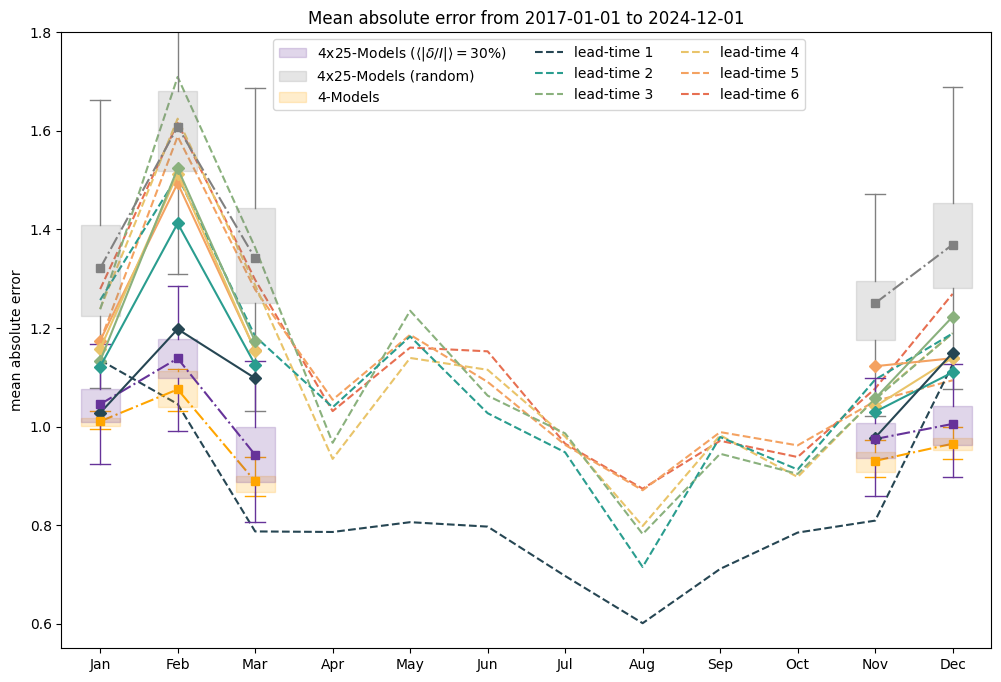

In [26]:
plt.figure(figsize=(12,8))
ax = plt.axes()
colors = ["#264653","#2a9d8f","#8ab17d","#e9c46a","#f4a261","#e76f51"]

# SEAS5 MAE
for leadtime in reversed(range(1, 7)):
    x = np.arange(leadtime - 1, (12 + leadtime - 1)) % 12 + 1
    s = seas5_mae.sel(forecastMonth=leadtime).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
    plt.plot(x[x.argsort()], s[x.argsort()], color=colors[leadtime-1], ls='--', label='lead-time %d' % leadtime)

# models output MAE
diff = abs(anom - models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot(diff, 'orange', f'{n_models}-Models')
plt.plot([1,2,3], diff.mean(dim=['number'])[:3], color='orange', ls='-.')
plt.plot([11,12], diff.mean(dim=['number'])[-2:], color='orange', ls='-.')

# random models output MAE
diff = abs(anom - rand_models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot(diff, 'gray', '%dx%d-Models (random)' % (n_models, N))
plt.plot([1,2,3], diff.mean(dim=['number', 'realization'])[:3], color='gray', ls='-.')
plt.plot([11,12], diff.mean(dim=['number', 'realization'])[-2:], color='gray', ls='-.')

# perturbed models output MAE
diff = abs(anom - pert_models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot(diff, 'rebeccapurple', r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100))
plt.plot([1,2,3], diff.mean(dim=['number', 'realization'])[:3], color='rebeccapurple', ls='-.')
plt.plot([11,12], diff.mean(dim=['number', 'realization'])[-2:], color='rebeccapurple', ls='-.')

# SEAS5 models output MAE
for leadtime in reversed(models_seas5_index_mae.forecastMonth.data):
    x = xs[leadtime-1]
    s = models_seas5_index_mae.sel(forecastMonth=leadtime).groupby('time.month').mean(dim=['time', 'lat', 'lon'])[x.argsort()]
    plt.plot([1,2,3], s[:3], marker='D', ls='-', color=colors[leadtime-1])
    plt.plot([11,12], s[3:], marker='D', ls='-', color=colors[leadtime-1])

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], ncol=3, loc='upper left',  bbox_to_anchor=(0.22, 1))
plt.ylabel('mean absolute error')
plt.title('Mean absolute error from %s to %s' % (start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')))
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylim(.55, 1.8)

In [27]:
legend_elements = [
    Line2D([0], [0], marker='o', color='gray', ls='', label='SEAS5'),
    Line2D([0], [0], marker='s', color='gray', ls='', label='Models trained on ERA5 indexes'),
    Line2D([0], [0], marker='D', color='gray', ls='', label='Models trained on ERA5\nwith bias-corrected SEAS5 indexes'),
    Line2D([0], [0], marker='*', markersize=10, color='gray', ls='', label='Models trained on non-bias-corrected\nSEAS5 indexes'),
    Patch(facecolor=colors[0], label='lead-time 1'),
    Patch(facecolor=colors[1], label='lead-time 2'),
    Patch(facecolor=colors[2], label='lead-time 3'),
    Patch(facecolor=colors[3], label='lead-time 4'),
    Patch(facecolor='indianred', label=f'{n_models}-Models'),
    Patch(facecolor='rebeccapurple', label=r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100)),
    Patch(facecolor='burlywood', label=f'{n_models}x{N}-Models (random)'),

]

Text(2, 1.69, 'ERA5')

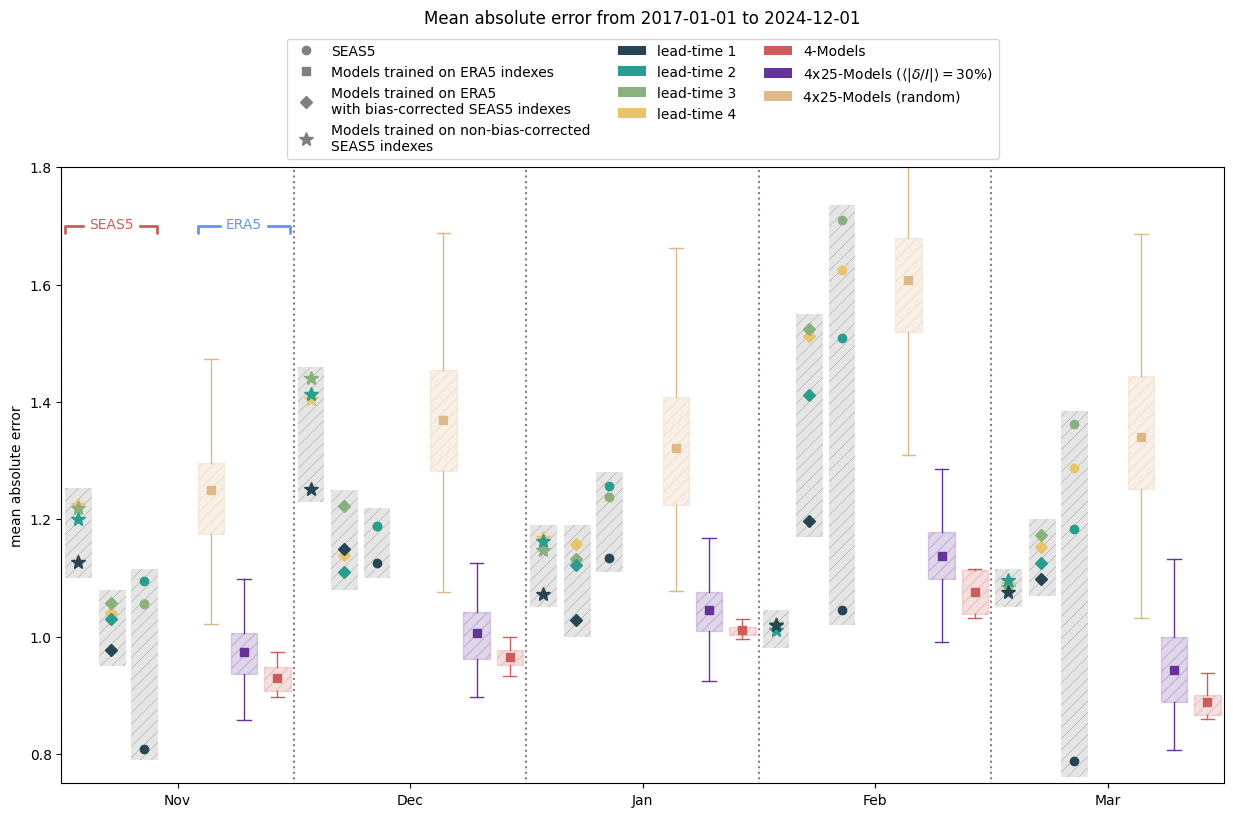

In [28]:
nq = 7
offset = 1
pos = np.arange(0, 5*nq, nq)
plt.figure(figsize=(15,8))
ax = plt.axes()
colors = ["#264653","#2a9d8f","#8ab17d","#e9c46a","#f4a261","#e76f51"]

for leadtime in reversed(range(1, 5)):
    x = np.arange(leadtime - 1, (12 + leadtime - 1)) % 12 + 1
    s = seas5_mae.sel(forecastMonth=leadtime).groupby('time.month').mean(dim=['time', 'lat', 'lon'])[x.argsort()]
    #plt.bar(pos-offset, np.append(s[-2:], s[:3]), color=colors[leadtime-1], alpha=.2)
    plt.plot(pos-offset, np.append(s[-2:], s[:3]), marker='o', ls='', color=colors[leadtime-1], label='lead-time %d' % leadtime)

ax.add_patch(Rectangle((pos[0]-offset-.4, .79), .8, .325, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-offset-.4, 1.1), .8, .12, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-offset-.4, 1.11), .8, .17, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-offset-.4, 1.02), .8, .715, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-offset-.4, .76), .8, .625, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

# models output MAE
diff = abs(anom - models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot_NDJFM(diff, 'indianred', f'{n_models}-Models', pos+3*offset)

# perturbed models output MAE
diff = abs(anom - pert_models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot_NDJFM(diff, 'rebeccapurple', r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100), pos+2*offset)

# random models output MAE
diff = abs(anom - rand_models_out).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
boxplot_NDJFM(diff, 'burlywood', f'{n_models}x{N}-Models (random)', pos+offset)

# models trained with SEAS5 index at different leadtime
for leadtime in reversed(range(1,5)):
    diff = abs(anom - seas5_models_out[leadtime-1]).groupby('time.month').mean(dim=['time', 'lat', 'lon'])
    #ax.bar(pos-3*offset, diff, color=colors[leadtime-1], alpha=.2)
    ax.plot(pos-3*offset, diff, marker='*', markersize=10, ls='', color=colors[leadtime-1])

ax.add_patch(Rectangle((pos[0]-3*offset-.38, 1.1), .8, .154, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-3*offset-.38, 1.23), .8, .23, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-3*offset-.38, 1.05), .8, .14, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-3*offset-.38, .98), .8, .065, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-3*offset-.38, 1.05), .8, .065, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

# models with SEAS5 indexes as input
for leadtime in reversed(range(1,5)):
    x = xs[leadtime-1]
    s = models_seas5_index_mae.sel(forecastMonth=leadtime).groupby('time.month').mean(dim=['time', 'lat', 'lon'])[x.argsort()]
    #ax.bar(pos-2*offset, np.append(s[-2:], s[:3]), color=colors[leadtime-1], alpha=.2)
    ax.plot(pos-2*offset, np.append(s[-2:], s[:3]), marker='D', ls='', color=colors[leadtime-1])

ax.add_patch(Rectangle((pos[0]-2*offset-.37, .95), .8, .13, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-2*offset-.37, 1.08), .8, .17, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-2*offset-.37, 1.), .8, .19, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-2*offset-.37, 1.17), .8, .38, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-2*offset-.37, 1.07), .8, .13, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

ax.legend(handles=legend_elements, ncol=3, loc='upper center',  bbox_to_anchor=(0.5, 1.22))
ax.set_ylabel('mean absolute error')
ax.set_title('Mean absolute error from %s to %s' % (start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')), y=1.22)
ax.set_xticks(pos, ['Nov','Dec','Jan','Feb','Mar'])
ax.set_ylim(.75, 1.8)
ax.vlines(pos-nq*offset/2, 0, 2, ls=':', color='gray')
ax.set_xlim(pos.min()-nq*offset/2, pos.max()+nq*offset/2)

ax.annotate('SEAS5', xy=(pos[0]-2*offset, 1.70), xytext=(pos[0]-2*offset, 1.69),fontsize=10, ha='center', va='bottom', color='indianred',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=3.3, lengthB=.5', lw=2.0, color='indianred'))
ax.annotate('ERA5', xy=(pos[0]+2*offset, 1.70), xytext=(pos[0]+2*offset, 1.69),fontsize=10, ha='center', va='bottom', color='cornflowerblue',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=3.3, lengthB=.5', lw=2.0, color='cornflowerblue'))

In [29]:
# DJF MAE
seas5_DJF_MAE              = abs(anom_DJF - seas5_DJF.mean(dim='number')).mean(dim='time')
models_DJF_MAE             = abs(anom_DJF - models_DJF.mean(dim='number')).mean(dim='time')
pert_models_DJF_MAE        = abs(anom_DJF - pert_models_DJF.mean(dim='number')).mean(dim=['realization', 'time'])
rand_models_DJF_MAE        = abs(anom_DJF - rand_models_DJF.mean(dim='number')).mean(dim=['realization', 'time'])
models_seas5_index_DJF_MAE = abs(anom_DJF - models_seas5_index_DJF.mean(dim=['ensemble_member', 'number'])).mean(dim=['time'])
seas5_models_DJF_MAE       = abs(anom_DJF - seas5_models_DJF).mean(dim='time')

Text(0.5, 0.98, 'Mean Absolute Error in DJF from 2017-01-01 to 2024-12-01')

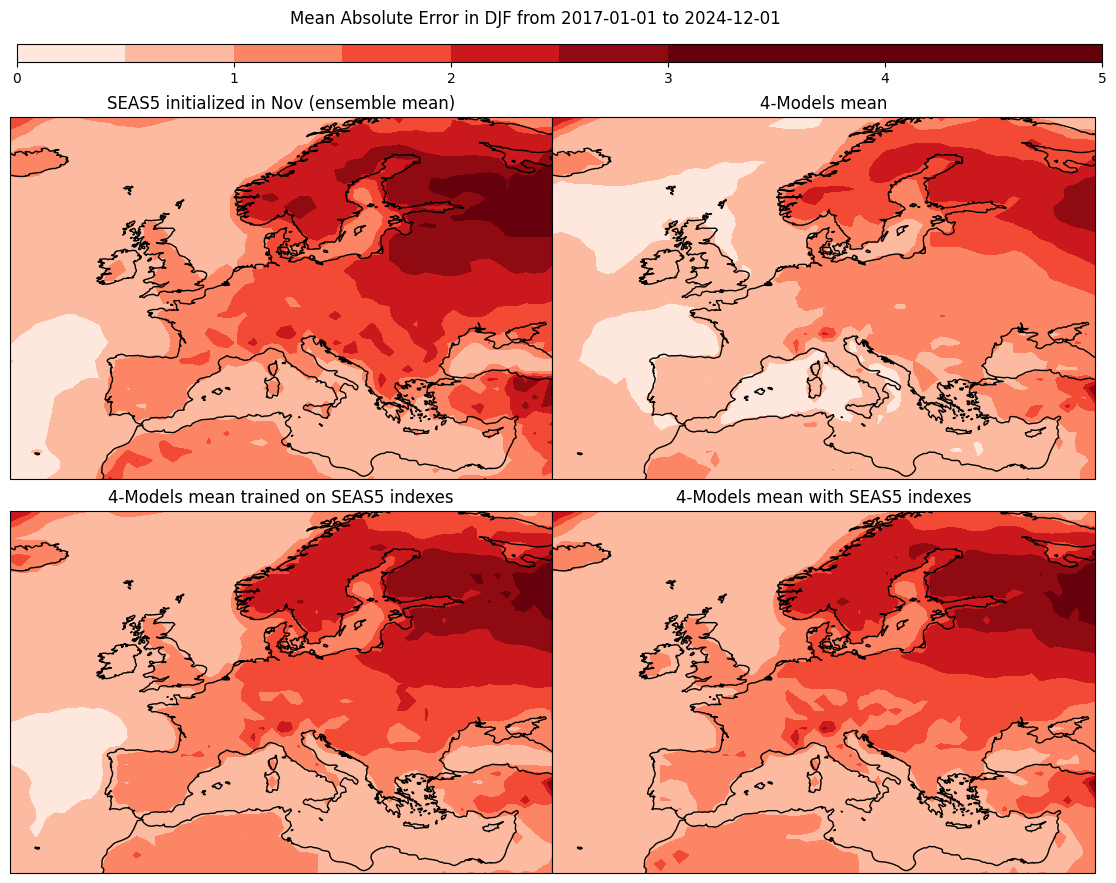

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10),
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace':0, 'hspace':.05}, 
                        subplot_kw={'projection': ccrs.PlateCarree()}
                        )
cmap = 'Reds'
vmin, vmax = 0, 3
ptresh = .05
levels = np.linspace(0, 5, 11)

axs[0,0].set_title('SEAS5 initialized in Nov (ensemble mean)')
axs[0,1].set_title(f'{n_models}-Models mean')
#axs[1,0].set_title(r"%dx%d-Models mean ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100))
axs[1,0].set_title(f"{n_models}-Models mean trained on SEAS5 indexes")
axs[1,1].set_title(f'{n_models}-Models mean with SEAS5 indexes')
axs[0,0].set_xlim(-20,40)
axs[0,0].set_ylim(30,70)
cax = inset_axes(axs[0,0], width="200%", height="5%", loc="upper left", bbox_to_anchor=(0.0, .22, 1, 1), bbox_transform=axs[0,0].transAxes)

pcm = axs[0,0].contourf(anom.lon, anom.lat, seas5_DJF_MAE, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[0,1].contourf(anom.lon, anom.lat, models_DJF_MAE, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
#axs[1,0].contourf(anom.lon, anom.lat, pert_models_DJF_MAE, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[1,0].contourf(anom.lon, anom.lat, seas5_models_DJF_MAE, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[1,1].contourf(anom.lon, anom.lat, models_seas5_index_DJF_MAE, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)

[axs[i,j].coastlines() for j in range(2) for i in range(2)]
fig.colorbar(pcm, cax=cax, orientation='horizontal', label='')
fig.suptitle('Mean Absolute Error in DJF from %s to %s' % (start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')))


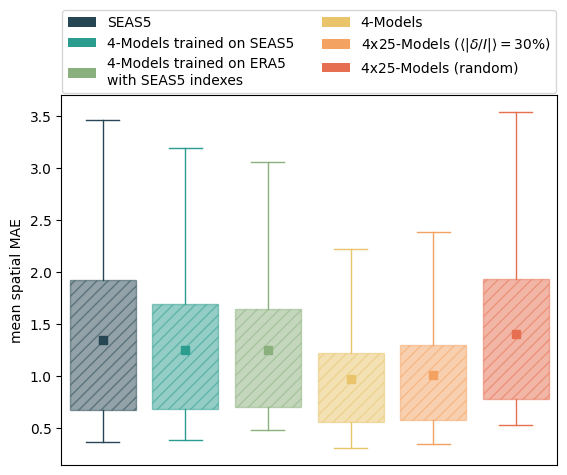

In [31]:
# MAE winter boxplot
ax = plt.axes()
legend_elements = [
    Patch(facecolor=colors[0], label=f'SEAS5'),
    Patch(facecolor=colors[1], label=f'{n_models}-Models trained on SEAS5'),
    Patch(facecolor=colors[2], label=f'{n_models}-Models trained on ERA5\nwith SEAS5 indexes'),
    Patch(facecolor=colors[3], label=f'{n_models}-Models'),
    Patch(facecolor=colors[4], label=r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100)),
    Patch(facecolor=colors[5], label=f'{n_models}x{N}-Models (random)'),
]

qs = [
    seas5_DJF_MAE.data.flatten(),
    seas5_models_DJF_MAE.data.flatten(),
    models_seas5_index_DJF_MAE.data.flatten(),
    models_DJF_MAE.data.flatten(),
    pert_models_DJF_MAE.data.flatten(),
    rand_models_DJF_MAE.data.flatten(),
    ]

loc = 0
for q, color in zip(qs, colors):
    bplot = ax.boxplot(
        q,
        positions=[loc,],
        patch_artist=True,
        showmeans=True, boxprops={'color': color},
        medianprops={'linewidth': 0, 'color': color}, 
        meanprops={'marker': 's', 'markeredgecolor': color, 'markerfacecolor': color}, 
        showfliers=False,
        whiskerprops={'color': color}, capprops = {'color': color},
        widths=.8,
    )
    [patch.set(facecolor=color, alpha=.5, hatch='///') for patch in bplot['boxes']]

    loc += 1
ax.legend(handles=legend_elements, ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.25))
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_ylabel('mean spatial MAE')
plt.show()

## Anomaly Correlation Coefficient

In [32]:
seas5_acc = xr.DataArray(
    dims=['forecastMonth', 'month', 'lat', 'lon'],
    coords=dict(
        month=range(1,13),
        forecastMonth=range(1,5),
        lat=seas5_anom.lat,
        lon=seas5_anom.lon
    ),
    data=np.array([[
        pearsonr(
            era5_anom.groupby('time.month')[(month + leadtime - 1) % 12 if (month + leadtime - 1) % 12 != 0 else 12],
            seas5_anom.sel(forecastMonth=leadtime).groupby('time.month')[month].mean(dim='number'), axis=0
            ).statistic
        for month in range(1,13)]
    for leadtime in range(1,5)])
)

models_acc = xr.DataArray(
    dims=['month', 'number', 'lat', 'lon'],
    coords=dict(
        month=months,
        number=range(n_models),
        lat=anom.lat,
        lon=anom.lon
    ),
    data=np.array([
        [pearsonr(
            anom.groupby('time.month')[month],
            models_out.groupby('time.month')[month].isel(number=i), axis=0).statistic
        for i in range(n_models)]
    for month in months])
)

pert_models_acc = xr.DataArray(
    dims=['month', 'realization', 'lat', 'lon'],
    coords=dict(
        month=months,
        realization=range(N),
        lat=anom.lat,
        lon=anom.lon
    ),
    data=np.array([
            [pearsonr(
                anom.groupby('time.month')[month],
                pert_models_out.groupby('time.month')[month].isel(realization=j).mean(dim='number'), axis=0).statistic  # n_models ensemble-mean
        for j in range(N)]
    for month in months])
)

rand_models_acc = xr.DataArray(
    dims=['month', 'realization', 'lat', 'lon'],
    coords=dict(
        month=months,
        realization=range(N),
        lat=anom.lat,
        lon=anom.lon
    ),
    data=np.array([
            [pearsonr(
                anom.groupby('time.month')[month],
                rand_models_out.groupby('time.month')[month].isel(realization=i).mean(dim='number'), axis=0).statistic  # n_models ensemble-mean
        for i in range(N)]
    for month in months])
)

seas5_models_acc = xr.DataArray(
    dims=['month', 'index_leadtime', 'lat', 'lon'],
    coords=dict(
        month=months,
        index_leadtime=range(1, len(seas5_models_out)+1),
        lat=anom.lat,
        lon=anom.lon
    ),
    data = np.array([
            [pearsonr(
                era5_anom.groupby('time.month')[month],
                seas5_models_out[i].groupby('time.month')[month], axis=0).statistic
        for i in range(len(seas5_models_out))]
    for month in months])
)

models_seas5_index_acc = xr.DataArray(
    dims=['month', 'forecastMonth', 'lat', 'lon'],
    coords=dict(
        month=months,
        forecastMonth=models_seas5_index.forecastMonth,
        lat=anom.lat,
        lon=anom.lon
    ),
    data=np.array([[
            pearsonr(
                era5_anom.groupby('time.month')[(month - leadtime + 1) % 12 if (month - leadtime + 1) % 12 != 0 else 12],
                models_seas5_index.sel(forecastMonth=leadtime).mean(dim=['ensemble_member', 'number']).groupby('time.month')[month],
                axis=0).statistic
            for leadtime in models_seas5_index.forecastMonth.data]
        for month in months]
    )
)

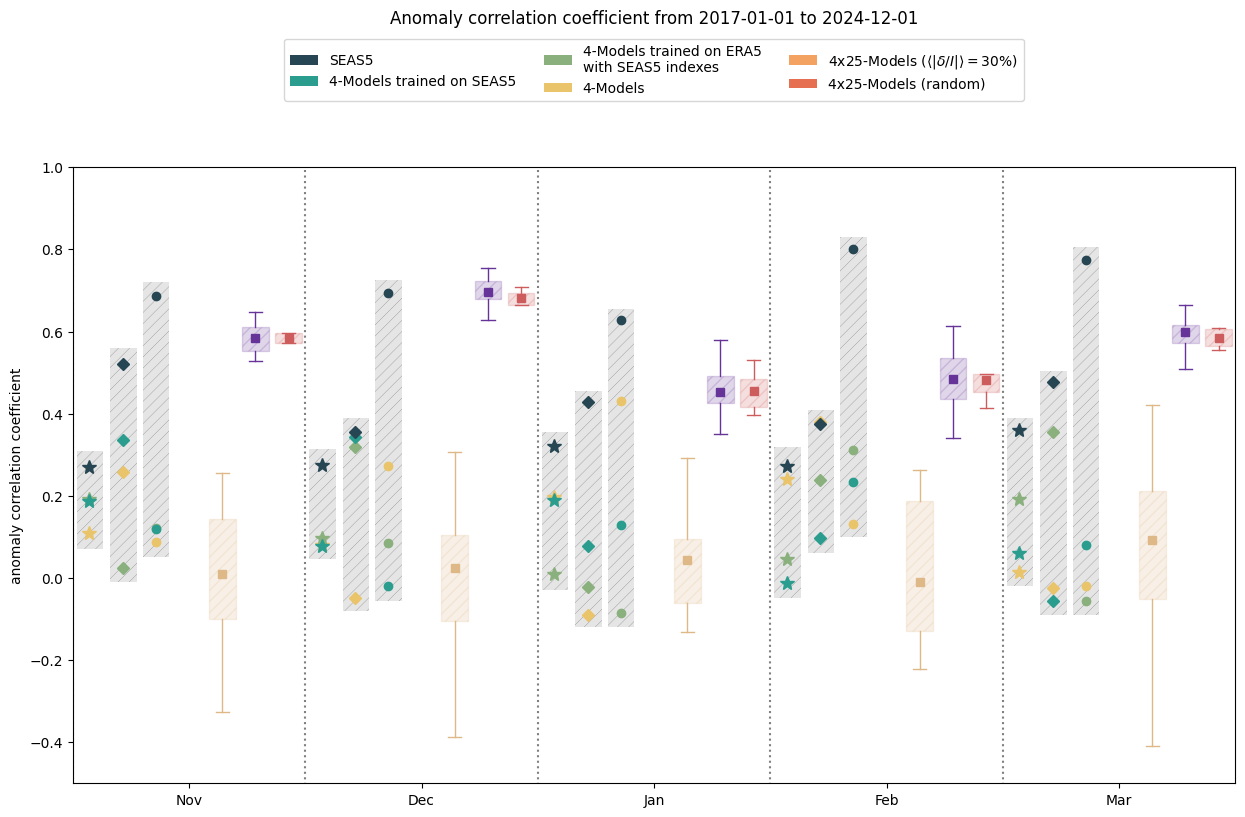

In [33]:
nq = 7
offset = 1
pos = np.arange(0, 5*nq, nq)
plt.figure(figsize=(15,8))
ax = plt.axes()
colors = ["#264653","#2a9d8f","#8ab17d","#e9c46a","#f4a261","#e76f51"]

for leadtime in reversed(range(1, 5)):
    x = np.arange(leadtime - 1, (12 + leadtime - 1)) % 12 + 1
    s = seas5_acc.sel(forecastMonth=leadtime, month=x).mean(dim=['lat', 'lon']).data[x.argsort()]
    plt.plot(pos-offset, np.append(s[-2:], s[:3]), marker='o', ls='', color=colors[leadtime-1], label='lead-time %d' % leadtime)



# models output MAE
boxplot_NDJFM(models_acc.mean(dim=['lat', 'lon']), 'indianred', f'{n_models}-Models', pos+3*offset)

# perturbed models output MAE
boxplot_NDJFM(pert_models_acc.mean(dim=['lat', 'lon']), 'rebeccapurple', r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100), pos+2*offset)

# random models output MAE
boxplot_NDJFM(rand_models_acc.mean(dim=['lat', 'lon']), 'burlywood', f'{n_models}x{N}-Models (random)', pos+offset)

# models trained with SEAS5 index at different leadtime
for leadtime in reversed(range(1,5)):
    ax.plot(pos-3*offset, seas5_models_acc.sel(index_leadtime=leadtime).mean(dim=['lat', 'lon']), marker='*', markersize=10, ls='', color=colors[leadtime-1])

ax.add_patch(Rectangle((pos[0]-3*offset-.38, .07), .8, .24, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-3*offset-.38, .045), .8, .27, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-3*offset-.38, -.03), .8, .385, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-3*offset-.38, -.05), .8, .37, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-3*offset-.38, -.02), .8, .41, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

# models with SEAS5 indexes as input
for leadtime in reversed(range(1,5)):
    x = xs[leadtime-1]
    s = models_seas5_index_acc.sel(forecastMonth=leadtime).mean(dim=['lat', 'lon'])
    ax.plot(pos-2*offset, np.append(s[-2:], s[:3]), marker='D', ls='', color=colors[leadtime-1])

ax.add_patch(Rectangle((pos[0]-2*offset-.37, -.01), .8, .57, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-2*offset-.37, -.08), .8, .47, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-2*offset-.37, -.12), .8, .575, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-2*offset-.37, 0.06), .8, .35, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-2*offset-.37, -.09), .8, .595, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

ax.legend(handles=legend_elements, ncol=3, loc='upper center',  bbox_to_anchor=(0.5, 1.22))
ax.set_ylabel('anomaly correlation coefficient')
ax.set_title('Anomaly correlation coefficient from %s to %s' % (start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')), y=1.22)
ax.set_xticks(pos, ['Nov','Dec','Jan','Feb','Mar'])
ax.set_ylim(-.5, 1)
ax.vlines(pos-nq*offset/2, -1, 1, ls=':', color='gray')
ax.set_xlim(pos.min()-nq*offset/2, pos.max()+nq*offset/2)

ax.annotate('SEAS5', xy=(pos[0]-2*offset, 1.70), xytext=(pos[0]-2*offset, 1.69),fontsize=10, ha='center', va='bottom', color='indianred',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=3.3, lengthB=.5', lw=2.0, color='indianred'))
ax.annotate('ERA5', xy=(pos[0]+2*offset, 1.70), xytext=(pos[0]+2*offset, 1.69),fontsize=10, ha='center', va='bottom', color='cornflowerblue',
            bbox=dict(boxstyle='square', ec='white', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=3.3, lengthB=.5', lw=2.0, color='cornflowerblue'))

ax.add_patch(Rectangle((pos[0]-offset-.4, .05), .8, .67, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[1]-offset-.4, -.055), .8, .78, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[2]-offset-.4, -.12), .8, .775, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[3]-offset-.4, .1), .8, .73, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))
ax.add_patch(Rectangle((pos[4]-offset-.4, -.09), .8, .895, hatch='///', facecolor='gray', hatch_linewidth=.1, alpha=.2))

In [34]:
month = 1

models_seas5_index_mean_acc_jan = pearsonr(
    anom.groupby('time.month')[month],
    models_seas5_index.sel(forecastMonth=3).groupby('time.month')[11].mean(dim=['ensemble_member', 'number']), axis=0).statistic

(30.0, 70.0)

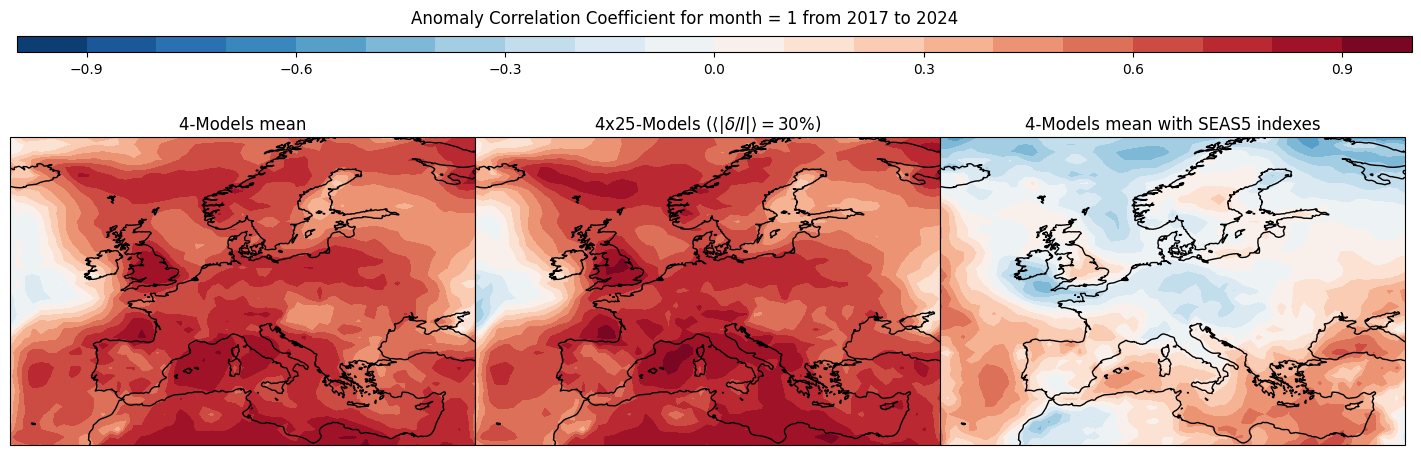

In [35]:
fig, axs = plt.subplots(1,3, figsize=(18,4), 
                        sharex=True, sharey=True, 
                        gridspec_kw=dict(wspace=0),
                        subplot_kw=dict(projection=ccrs.PlateCarree()))
cmap = 'RdBu_r'
vmin, vmax = -1, 1
levels = np.linspace(-1, 1, 21)
fig.suptitle('Anomaly Correlation Coefficient for month = %d from %s to %s' % (month, start.strftime('%Y'), end.strftime('%Y')), y=1.2)
cax = inset_axes(axs[0], width="300%", height="5%", loc="upper left", bbox_to_anchor=(0.0, .3, 1, 1.05), bbox_transform=axs[0].transAxes)
axs[0].set_title(f'{n_models}-Models mean')
axs[1].set_title(r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100))
axs[2].set_title(f'{n_models}-Models mean with SEAS5 indexes')

cf = axs[0].contourf(anom.lon, anom.lat, models_acc.sel(month=1).mean(dim='number'), cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[1].contourf(anom.lon, anom.lat, pert_models_acc.sel(month=1).mean(dim=['realization']), cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
#axs[2].contourf(anom.lon, anom.lat, rand_models_acc.sel(month=1).mean(dim=['realization']), cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[2].contourf(anom.lon, anom.lat, models_seas5_index_mean_acc_jan, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
[axs[i].coastlines() for i in range(len(axs))]
[axs[i].set_aspect('auto') for i in range(len(axs))]

fig.colorbar(cf, cax=cax, orientation='horizontal', label='')
axs[0].set_xlim(-20,40)
axs[0].set_ylim(30,70)

In [36]:
seas5_DJF_ACC        = pearsonr(anom_DJF, seas5_DJF.mean(dim='number'), axis=0)
models_DJF_ACC       = pearsonr(anom_DJF, models_DJF.mean(dim='number'), axis=0)
pert_models_DJF_ACC  = np.mean(
    [pearsonr(anom_DJF, pert_models_DJF.isel(realization=i).mean(dim='number'), axis=0) for i in range(N)]
    , axis=0)
rand_models_DJF_ACC  = np.mean(
    [pearsonr(anom_DJF, rand_models_DJF.isel(realization=i).mean(dim='number'), axis=0) for i in range(N)]
    , axis=0)
models_seas5_index_DJF_ACC = pearsonr(anom_DJF, models_seas5_index_DJF.mean(dim=['ensemble_member', 'number']), axis=0)
seas5_models_DJF_ACC = pearsonr(anom_DJF, seas5_models_DJF, axis=0)

Text(0.5, 0.98, 'Anomaly Correlation Coefficient in DJF from 2017-01-01 to 2024-12-01')

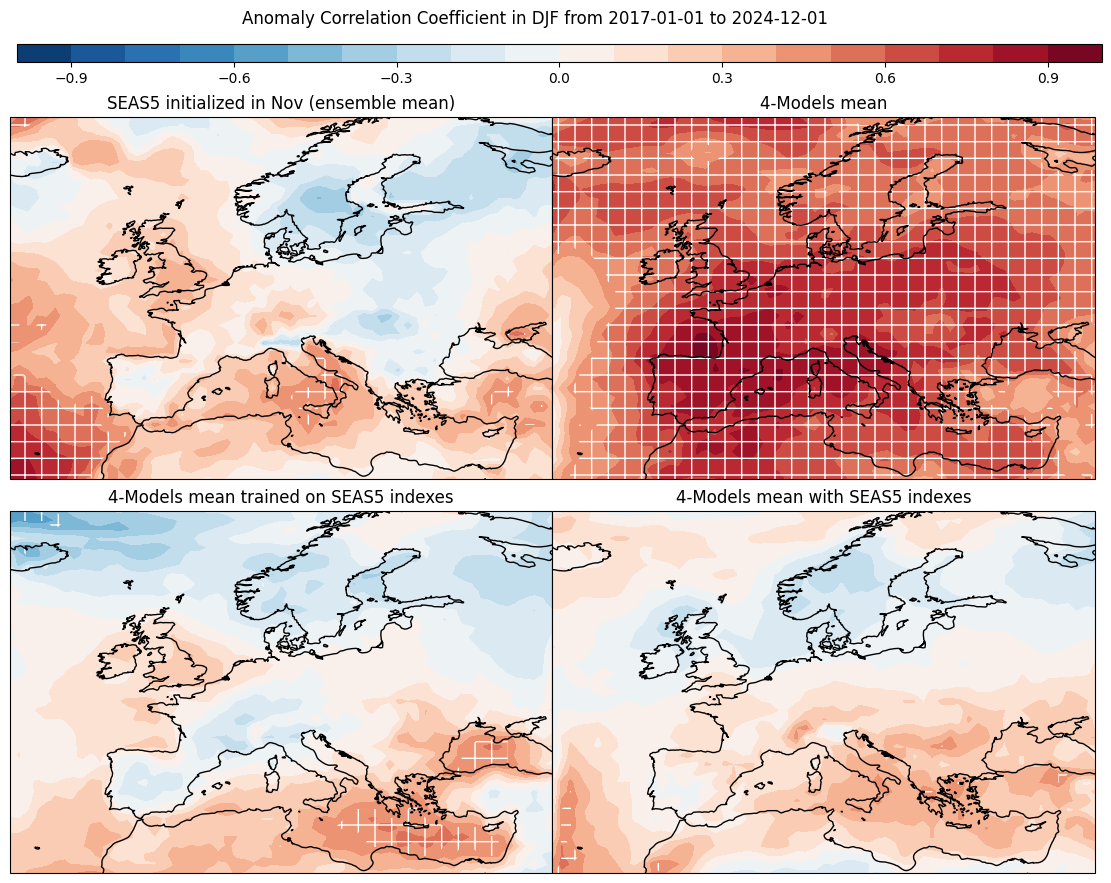

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10),
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace':0, 'hspace':.05}, 
                        subplot_kw={'projection': ccrs.PlateCarree()}
                        )
cmap = 'RdBu_r'
vmin, vmax = -1, 1
ptresh = .05
levels = np.linspace(-1, 1, 21)

axs[0,0].set_title('SEAS5 initialized in Nov (ensemble mean)')
axs[0,1].set_title(f'{n_models}-Models mean')
#axs[1,0].set_title(r"%dx%d-Models mean ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100))
axs[1,0].set_title(f"{n_models}-Models mean trained on SEAS5 indexes")
axs[1,1].set_title(f'{n_models}-Models mean with SEAS5 indexes')
axs[0,0].set_xlim(-20,40)
axs[0,0].set_ylim(30,70)
cax = inset_axes(axs[0,0], width="200%", height="5%", loc="upper left", bbox_to_anchor=(0.0, .22, 1, 1), bbox_transform=axs[0,0].transAxes)

pcm = axs[0,0].contourf(anom.lon, anom.lat, seas5_DJF_ACC.statistic, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[0,1].contourf(anom.lon, anom.lat, models_DJF_ACC.statistic, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
#axs[1,0].contourf(anom.lon, anom.lat, pert_models_DJF_ACC[0], cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[1,0].contourf(anom.lon, anom.lat, seas5_models_DJF_ACC[0], cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)
axs[1,1].contourf(anom.lon, anom.lat, models_seas5_index_DJF_ACC.statistic, cmap=cmap, vmin=vmin, vmax=vmax, levels=levels)

# hatches
h = axs[0,0].contourf(anom.lon, anom.lat, seas5_DJF_ACC.pvalue < ptresh, hatches=['+', None], colors='none', vmin=vmin, vmax=vmax, levels=[1-ptresh,1])
h._hatch_color = (1,1,1,1)
h = axs[0,1].contourf(anom.lon, anom.lat, models_DJF_ACC.pvalue < ptresh, hatches=['+', None], colors='none', vmin=vmin, vmax=vmax, levels=[1-ptresh,1])
h._hatch_color = (1,1,1,1)
#h = axs[1,0].contourf(anom.lon, anom.lat, pert_models_DJF_ACC[1] < ptresh, hatches=['+', None], colors='none', vmin=vmin, vmax=vmax, levels=[1-ptresh,1])
h = axs[1,0].contourf(anom.lon, anom.lat, seas5_models_DJF_ACC[1] < ptresh, hatches=['+', None], colors='none', vmin=vmin, vmax=vmax, levels=[1-ptresh,1])
h._hatch_color = (1,1,1,1)
h = axs[1,1].contourf(anom.lon, anom.lat, models_seas5_index_DJF_ACC.pvalue < ptresh, hatches=['+', None], colors='none', vmin=vmin, vmax=vmax, levels=[1-ptresh,1])
h._hatch_color = (1,1,1,1)

[axs[i,j].coastlines() for j in range(2) for i in range(2)]
fig.colorbar(pcm, cax=cax, orientation='horizontal', label='')
fig.suptitle('Anomaly Correlation Coefficient in DJF from %s to %s' % (start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')))


In [38]:
bplot = ax.boxplot([
    seas5_DJF_ACC[0].flatten(),
    ],
    patch_artist=True,
    showmeans=True, boxprops={'color': colors[0]},
    medianprops={'linewidth': 0, 'color': colors[0]}, 
    meanprops={'marker': 's', 'markeredgecolor': colors[0], 'markerfacecolor': colors[0]}, 
    showfliers=False,
    whiskerprops={'color': colors[0]}, capprops = {'color': colors[0]},
    widths=.8,
)
[patch.set(facecolor=colors[0], alpha=.2, hatch='///') for patch in bplot['boxes']]

[[None, None, None]]

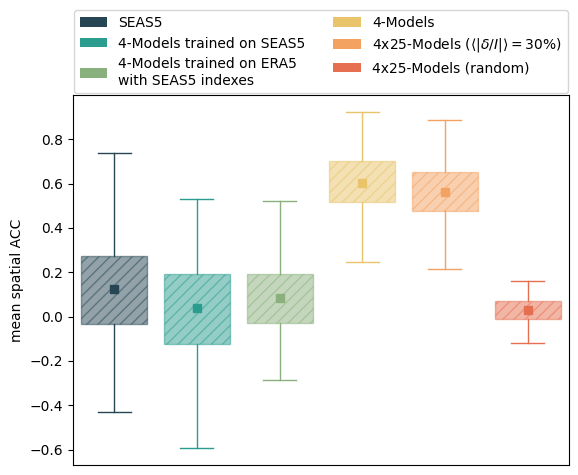

In [39]:
# ACC winter boxplot
ax = plt.axes()
legend_elements = [
    Patch(facecolor=colors[0], label=f'SEAS5'),
    Patch(facecolor=colors[1], label=f'{n_models}-Models trained on SEAS5'),
    Patch(facecolor=colors[2], label=f'{n_models}-Models trained on ERA5\nwith SEAS5 indexes'),
    Patch(facecolor=colors[3], label=f'{n_models}-Models'),
    Patch(facecolor=colors[4], label=r"%dx%d-Models ($\langle |\delta/I| \rangle = %d$%%)"  % (n_models, N, idx_mare * 100)),
    Patch(facecolor=colors[5], label=f'{n_models}x{N}-Models (random)'),
]

qs = [
    seas5_DJF_ACC[0].flatten(),
    seas5_models_DJF_ACC[0].flatten(),
    models_seas5_index_DJF_ACC[0].flatten(),
    models_DJF_ACC[0].flatten(),
    pert_models_DJF_ACC[0].flatten(),
    rand_models_DJF_ACC[0].flatten(),
    ]

loc = 0
for q, color in zip(qs, colors):
    bplot = ax.boxplot(
        q,
        positions=[loc,],
        patch_artist=True,
        showmeans=True, boxprops={'color': color},
        medianprops={'linewidth': 0, 'color': color}, 
        meanprops={'marker': 's', 'markeredgecolor': color, 'markerfacecolor': color}, 
        showfliers=False,
        whiskerprops={'color': color}, capprops = {'color': color},
        widths=.8,
    )
    [patch.set(facecolor=color, alpha=.5, hatch='///') for patch in bplot['boxes']]

    loc += 1
ax.legend(handles=legend_elements, ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.25))
ax.set_xticklabels('')
ax.set_xticks([])
ax.set_ylabel('mean spatial ACC')
plt.show()

# Max MARE

Such that both MAE and ACC for the winter season are equal to SEAS5

In [42]:
mare     = 0.
eps      = .1
mean_err = 0
N        = 25
max_mare = 1.5

seas5_DJF_avg_MAE = seas5_DJF_MAE.mean().data
seas5_DJF_avg_ACC = seas5_DJF_ACC.statistic.mean()

print(f'realizations = {N}, inital MARE = {mare}, eps = {eps}')
print('               MAE      ACC')
print(f'SEAS5         {seas5_DJF_avg_MAE:.3}     {seas5_DJF_avg_ACC:.3}')
print('-------------------------------------------------')
print('MARE')

pert_models_DJF_avg_MAE = []
pert_models_DJF_avg_ACC = []
pert_idxs = np.zeros((N, *idxs.shape))
while mare <= max_mare:#True:
    sigma     = sigma_from_mu_and_mare(mean_err, mare)
    f         = np.random.normal(loc=mean_err, scale=sigma, size=(N, *idxs.shape))

    # compute the perturbations
    for i in range(N):
        pert_idxs[i] = idxs.data * (1 + f[i])


    # transform to xarray for convenience
    pert_idxs = xr.DataArray(
        data=pert_idxs,
        dims=['realization', 'mode', 'time'],
        coords=dict(
            time=idxs.time,
            mode=idxs.mode,
            realization=range(1, N+1)
        )
    )

    # model's output with perturbed indexes
    pert_models_out = get_perturbed_models_out(model, pert_idxs).sel(time=slice(start, end))

    # winter season 
    pert_models_DJF = pert_models_out.transpose('time', 'lat', 'lon', 'number', 'realization')[np.isin(pert_models_out.time.dt.month, (12,1,2))]
    pert_models_DJF = pert_models_DJF.sel(time=slice(DJF_start, DJF_end))

    # winter season MAE
    pert_models_DJF_avg_MAE.append(abs(anom_DJF - pert_models_DJF.mean(dim='number')).mean().data)

    # winter season ACC
    pert_models_DJF_avg_ACC.append(np.mean(
        [pearsonr(anom_DJF, pert_models_DJF.isel(realization=i).mean(dim='number'), axis=0).statistic for i in range(N)]
    ))


    print(f'{mare:.3}           {pert_models_DJF_avg_MAE[-1]:.3}     {pert_models_DJF_avg_ACC[-1]:.3}')
    if (pert_models_DJF_avg_MAE[-1] < seas5_DJF_avg_MAE) and (pert_models_DJF_avg_ACC[-1] > seas5_DJF_avg_ACC):
        mare += eps
    else:
        mare += eps #break


realizations = 25, inital MARE = 0.0, eps = 0.1
               MAE      ACC
SEAS5         1.34     0.125
-------------------------------------------------
MARE
0.0           0.97     0.603
0.1           0.977     0.597
0.2           0.989     0.581
0.3           1.02     0.563
0.4           1.04     0.537
0.5           1.07     0.513
0.6           1.11     0.482
0.7           1.17     0.438
0.8           1.22     0.401
0.9           1.27     0.368
1.0           1.32     0.378


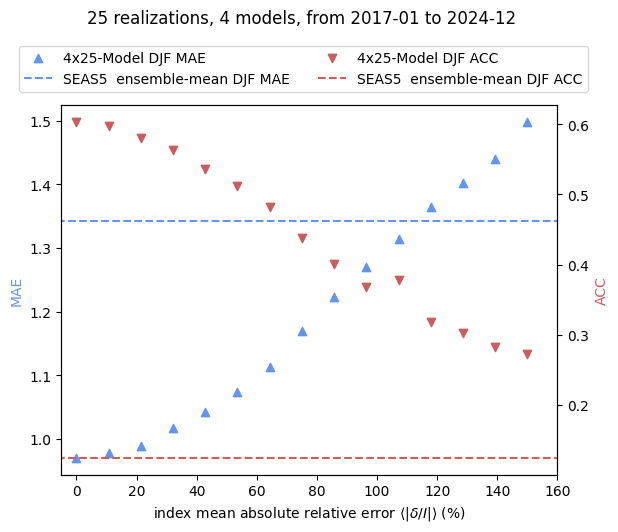

In [98]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
fig.suptitle(f'{N} realizations, {n_models} models, from {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}', y=1.08)
ax1.set_xlabel(r'index mean absolute relative error $\langle |\delta / I| \rangle$ (%)')
ax2.set_ylabel('ACC', color='indianred')
ax1.set_ylabel('MAE', color='cornflowerblue')
ax1.set_xlim(-5, 160)

x = np.linspace(0,mare, len(pert_models_DJF_avg_MAE)) * 100
ax1.scatter(x, pert_models_DJF_avg_MAE, marker='^', label=f'{n_models}x{N}-Model DJF MAE', color='cornflowerblue')
ax2.scatter(x, pert_models_DJF_avg_ACC, marker='v', label=f'{n_models}x{N}-Model DJF ACC', color='indianred')
ax1.hlines(seas5_DJF_avg_MAE, -10, 200, color='cornflowerblue', ls='--', label='SEAS5  ensemble-mean DJF MAE')
ax2.hlines(seas5_DJF_avg_ACC, -10, 200, color='indianred', ls='--', label='SEAS5  ensemble-mean DJF ACC')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(np.hstack([handles1, handles2]), np.hstack([labels1, labels2]), loc='upper left', ncol=2, bbox_to_anchor=(-.1, 1.18))